In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!python3 -c "import torch; print(torch.__version__)"

1.13.1+cu116


In [3]:
#!pip3 install torch torchvision
import torch
import torch.nn as nn
import numpy as np
from numpy import inf

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
torch.manual_seed(0)

In [ ]:
threshold=10000
def act_fn(x):
    return torch.clamp(x, min=-threshold, max=threshold)

In [ ]:
class MLPModule(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=2, act_fn=torch.tanh):
        super().__init__()
        self.layers = nn.ModuleList([nn.Linear(input_dim, hidden_dim)])
        for i in range(num_layers - 2):
            self.layers.append(nn.Linear(hidden_dim, hidden_dim))
        self.layers.append(nn.Linear(hidden_dim, output_dim))
        self.act_fn = act_fn

    def forward(self, x):
        for layer in self.layers:
            x = self.act_fn(layer(x))
        return torch.sigmoid(x)

In [ ]:
class MeanGNNLayer(nn.Module):
    
    def __init__(self, input_dim, output_dim):
        super().__init__()
        lim = 1  
        self.w_neigh = -2 * lim * torch.rand(input_dim, output_dim) + lim

    def forward(self, node_feats, adj_matrix):
        adj_matrix = adj_matrix + torch.eye(len(adj_matrix))
        degrees = adj_matrix.sum(axis=0)
        degrees = 1 / degrees
        degrees[degrees==inf] = 0
        adj_matrix = torch.mm(torch.diag(degrees), adj_matrix)
        node_feats_neigh = torch.mm(torch.mm(adj_matrix, node_feats), self.w_neigh)
        next_node_feats = node_feats_neigh
        return next_node_feats

In [ ]:
class MeanGNNModule(nn.Module):

    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=2, act_fn=act_fn):
        super().__init__()
        self.layers = nn.ModuleList([MeanGNNLayer(input_dim, hidden_dim)])
        for i in range(num_layers - 2):
            self.layers.append(MeanGNNLayer(hidden_dim, hidden_dim))
        self.layers.append(MeanGNNLayer(hidden_dim, output_dim))
        self.act_fn = act_fn

    def forward(self, x, adj_matrix):
        for layer in self.layers:
            x = self.act_fn(layer(x, adj_matrix))
        return x

In [ ]:
csv = []

for d in [128]:
    for r in [0.5]:
        for num_layers in [1,2,3]:
            for mpnn_idx in range(10):  # There will be 10 plots.
                # Initialize random BaseGNN model with sum aggregation.
                selfgnn = MeanGNNModule(input_dim=d, hidden_dim=d, output_dim=d,
                                         num_layers=num_layers, act_fn=act_fn)

                # Initialize random MLP classifier acting on final mean-pooled embedding.
                mlp = MLPModule(input_dim=d, hidden_dim=100, output_dim=1, 
                            num_layers=2, act_fn=torch.tanh)

                torch.save(selfgnn,f"/content/drive/MyDrive/Colab Notebooks/.../GNN0-1/SelfGNN/selfgnn_num_{num_layers}_mpnn_{mpnn_idx}.pth")
                torch.save(mlp,f"/content/drive/MyDrive/Colab Notebooks/.../GNN0-1/SelfGNN/mlp_num_{num_layers}_mpnn_{mpnn_idx}.pth")


                # Keep track of proportions of graphs classified as 1.
                proportions = []

                # Create plot with x-axis an increasing seq of number of graph nodes.
                #[10, 50, 100, 500, 1000, 2000, 5000]
                for graph_dim in [10, 50, 100, 500, 1000, 2000, 5000]:

                  # Generate 32 graphs for each such graph dimension, to keep
                  # track of the proportion that is classified as 1. 
                    classifications = []

                    for idx in range(2**5):
                        # Generate graph to be fed to the BaseGNN.
                        half_matrix = torch.bernoulli(r * (torch.triu(torch.ones(graph_dim, graph_dim)) -
                                              torch.eye(graph_dim)))
                        adj_matrix = half_matrix + half_matrix.T
                        initial_node_feats = torch.rand(graph_dim, d) 

                        # Obtain final mean-pooled embedding vector over all graph_dim nodes.
                        output = selfgnn(initial_node_feats, adj_matrix).mean(axis=0)
                        #print(output)

                        # Apply MLP classifier to the resulting output.
                        apply_classifier = mlp(output)

                        # If smaller than 1/2, output 0, else output 1.
                        if apply_classifier <= 0.5:
                            classifications.append(0)
                        else:
                            classifications.append(1)

                    # Calculate proportion of graphs classified as 1.
                    classifications = np.array(classifications)
                    proportions.append((classifications == 1).sum())

                csv.append([d,r,num_layers, mpnn_idx, proportions])
                print(csv[-1])


[128, 0.5, 1, 0, [32, 32, 32, 32, 32, 32, 32]]
[128, 0.5, 1, 1, [2, 0, 0, 0, 0, 0, 0]]
[128, 0.5, 1, 2, [0, 0, 0, 0, 0, 0, 0]]
[128, 0.5, 1, 3, [0, 0, 0, 0, 0, 0, 0]]
[128, 0.5, 1, 4, [3, 0, 0, 0, 0, 0, 0]]
[128, 0.5, 1, 5, [32, 32, 32, 32, 32, 32, 32]]
[128, 0.5, 1, 6, [32, 32, 32, 32, 32, 32, 32]]
[128, 0.5, 1, 7, [20, 4, 1, 0, 0, 0, 0]]
[128, 0.5, 1, 8, [0, 0, 0, 0, 0, 0, 0]]
[128, 0.5, 1, 9, [2, 2, 1, 0, 0, 0, 0]]
[128, 0.5, 2, 0, [11, 21, 24, 32, 32, 32, 32]]
[128, 0.5, 2, 1, [1, 0, 0, 0, 0, 0, 0]]
[128, 0.5, 2, 2, [29, 32, 32, 32, 32, 32, 32]]
[128, 0.5, 2, 3, [8, 18, 18, 31, 32, 32, 32]]
[128, 0.5, 2, 4, [32, 32, 32, 32, 32, 32, 32]]
[128, 0.5, 2, 5, [0, 0, 0, 0, 0, 0, 0]]
[128, 0.5, 2, 6, [2, 0, 0, 0, 0, 0, 0]]
[128, 0.5, 2, 7, [0, 0, 0, 0, 0, 0, 0]]
[128, 0.5, 2, 8, [32, 32, 32, 32, 32, 32, 32]]
[128, 0.5, 2, 9, [7, 5, 1, 0, 0, 0, 0]]
[128, 0.5, 3, 0, [26, 29, 30, 31, 32, 32, 32]]
[128, 0.5, 3, 1, [2, 0, 0, 0, 0, 0, 0]]
[128, 0.5, 3, 2, [5, 0, 0, 0, 0, 0, 0]]
[128, 0.5, 3, 3, 

In [8]:
import matplotlib.pyplot as plt
import pickle

In [ ]:
#generate 3 
csv_numLayer_1 = [item[-1] for item in csv if item[2] == 1]
csv_numLayer_2 = [item[-1] for item in csv if item[2] == 2]
csv_numLayer_3 = [item[-1] for item in csv if item[2] == 3]

In [ ]:
path_1 = f"/content/drive/MyDrive/Colab Notebooks/.../GNN0-1/SelfGNN/base_gnn_num_1.pickle"
with open(path_1, 'wb') as handle:
    pickle.dump(csv_numLayer_1,handle)

path_2 = f"/content/drive/MyDrive/Colab Notebooks/.../GNN0-1/SelfGNN/base_gnn_num_2.pickle"
with open(path_2, 'wb') as handle:
    pickle.dump(csv_numLayer_2,handle)

path_3 = f"/content/drive/MyDrive/Colab Notebooks/.../GNN0-1/SelfGNN/base_gnn_num_3.pickle"
with open(path_3, 'wb') as handle:
    pickle.dump(csv_numLayer_3,handle)

In [9]:
path_1 = f"/content/drive/MyDrive/Colab Notebooks/.../GNN0-1/SelfGNN/base_gnn_num_1.pickle"
with open(path_1, 'rb') as handle:
    csv_numLayer_1 = pickle.load(handle)

path_2 = f"/content/drive/MyDrive/Colab Notebooks/.../GNN0-1/SelfGNN/base_gnn_num_2.pickle"
with open(path_2, 'rb') as handle:
    csv_numLayer_2 = pickle.load(handle)

path_3 = f"/content/drive/MyDrive/Colab Notebooks/.../GNN0-1/SelfGNN/base_gnn_num_3.pickle"
with open(path_3, 'rb') as handle:
    csv_numLayer_3 = pickle.load(handle)

In [10]:
x = [10, 50, 100, 500, 1000, 2000, 5000]
#x = [10,50,100]

In [11]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 600

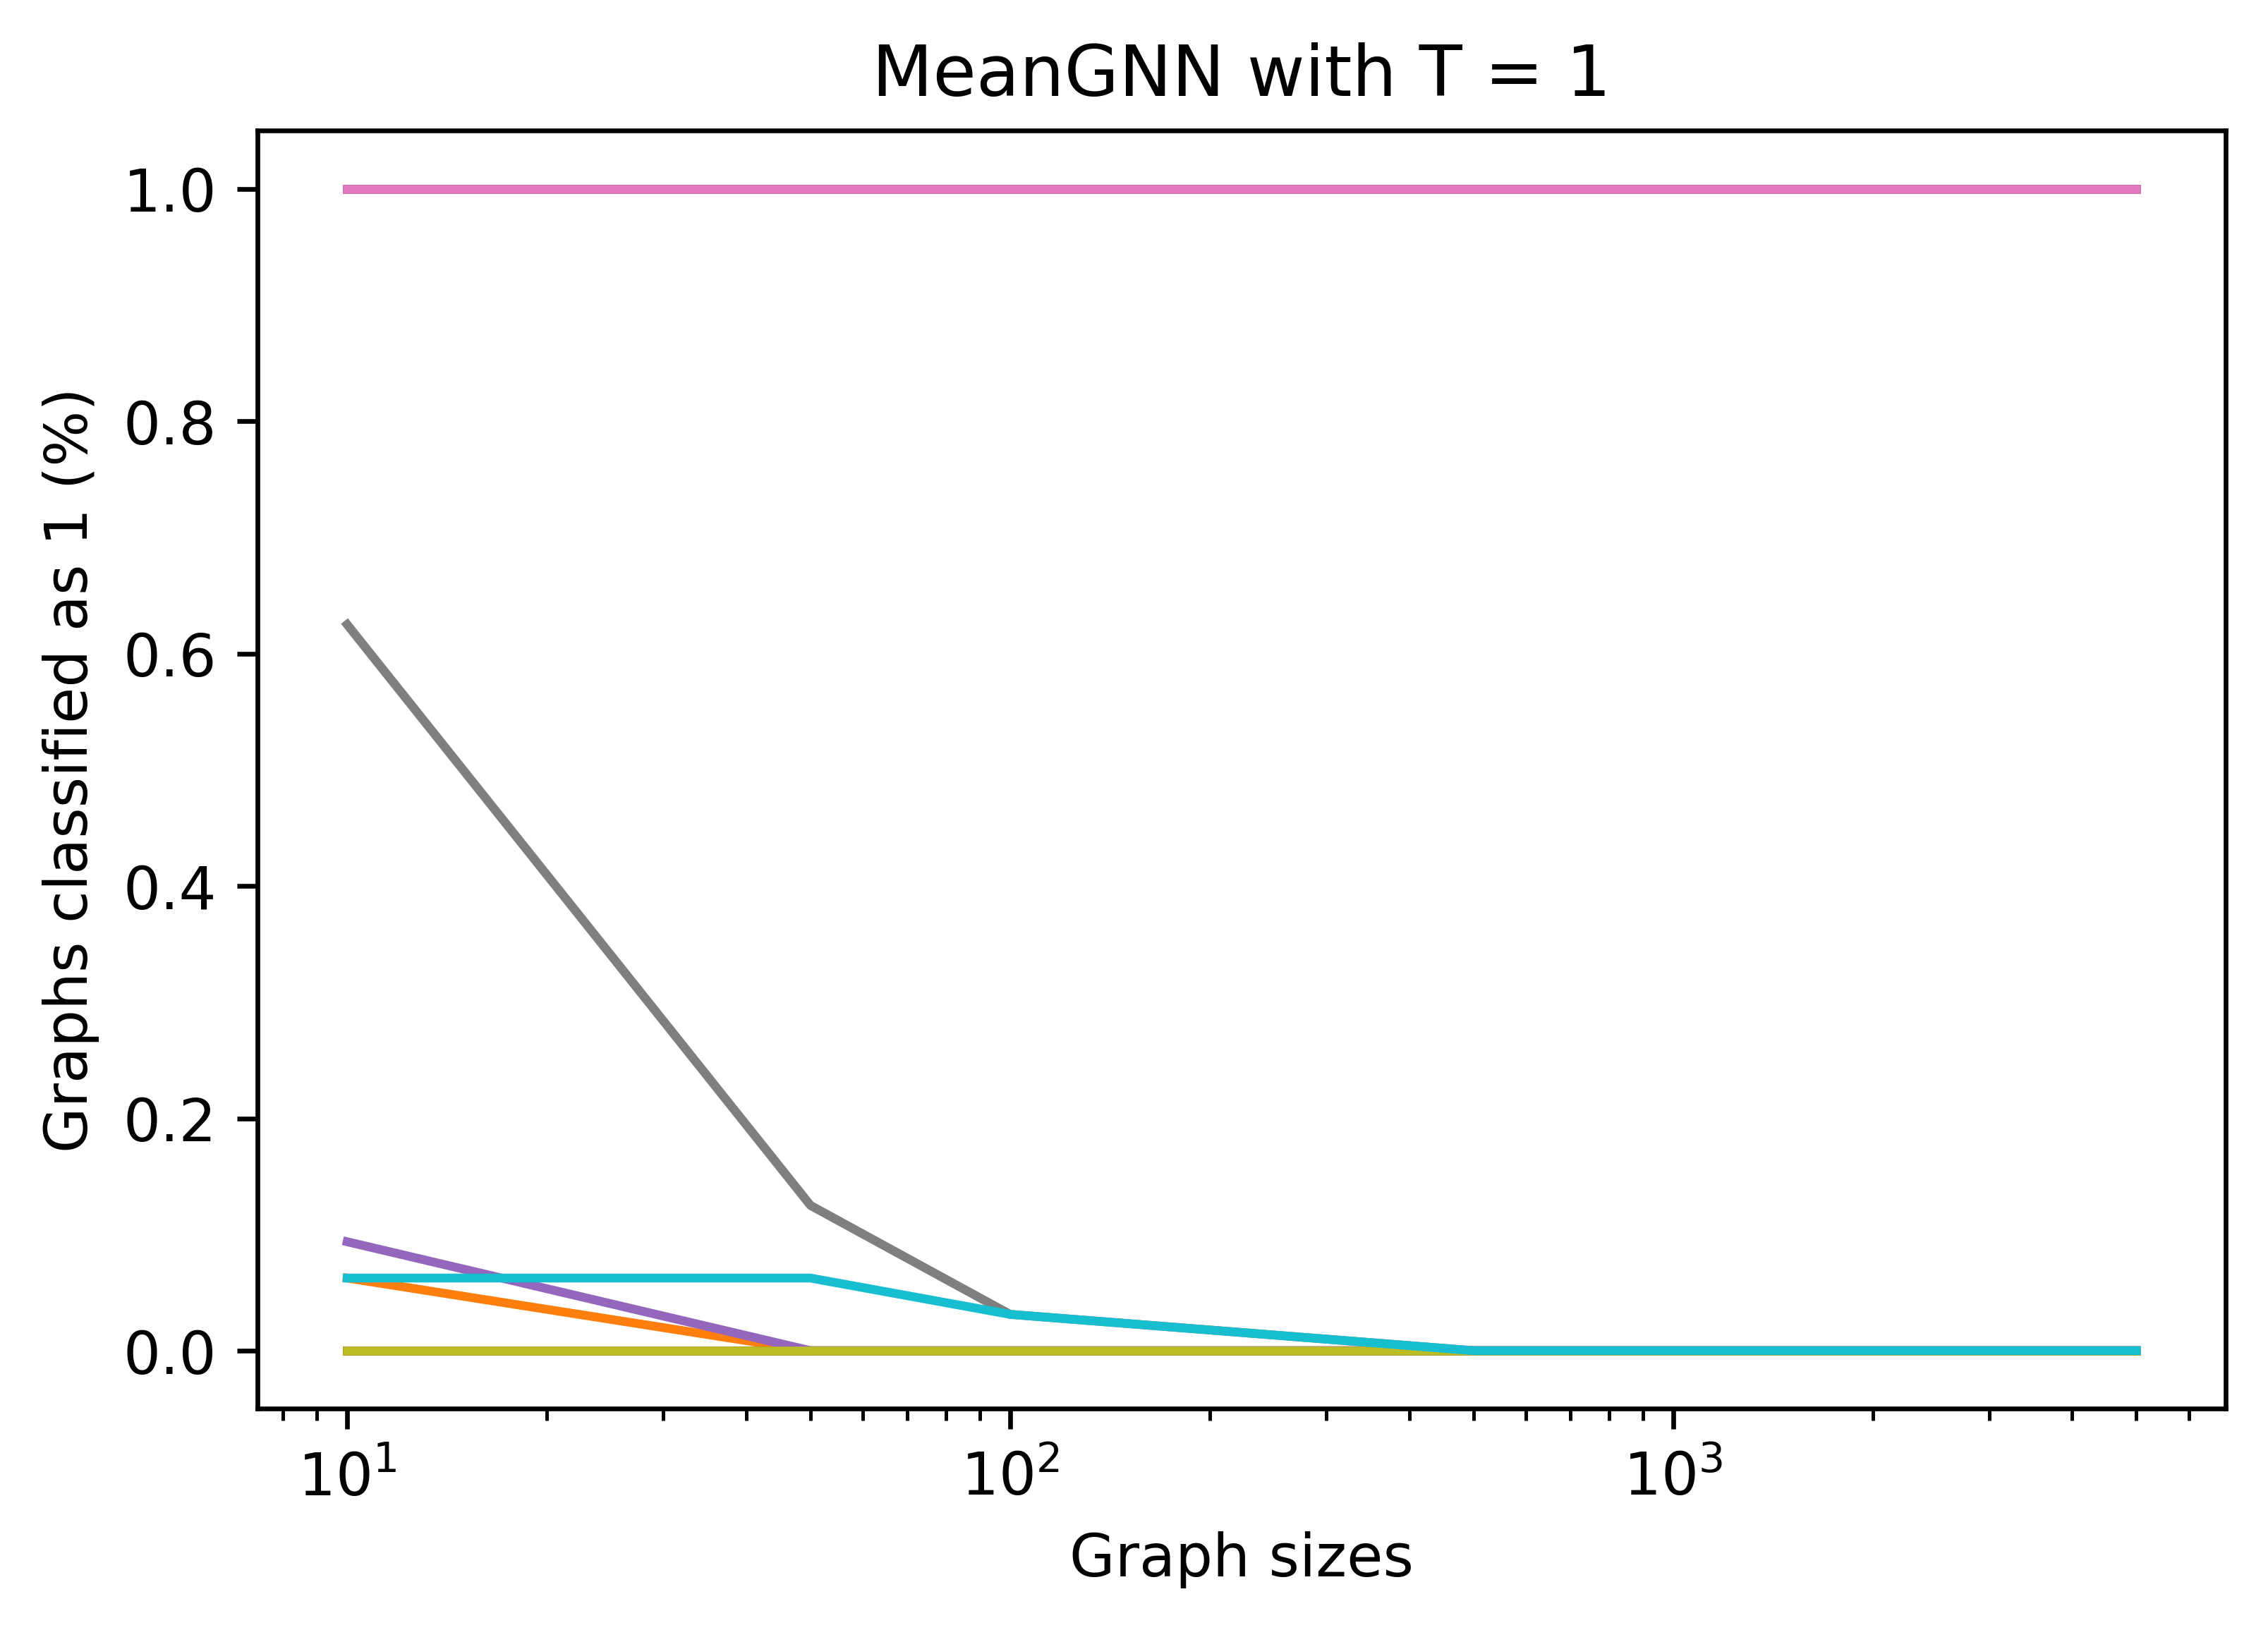

In [12]:
for y in csv_numLayer_1:
  y = [item/32 for item in y]
  plt.plot(x,y)# divide by 32

plt.xlabel('Graph sizes')
plt.ylabel('Graphs classified as 1 (%)')
plt.xscale("log")
plt.title(f'MeanGNN with T = 1')
plt.savefig('/content/drive/MyDrive/Colab Notebooks/.../GNN0-1/SelfGNN/MeanGNN with T = 1')
plt.show()

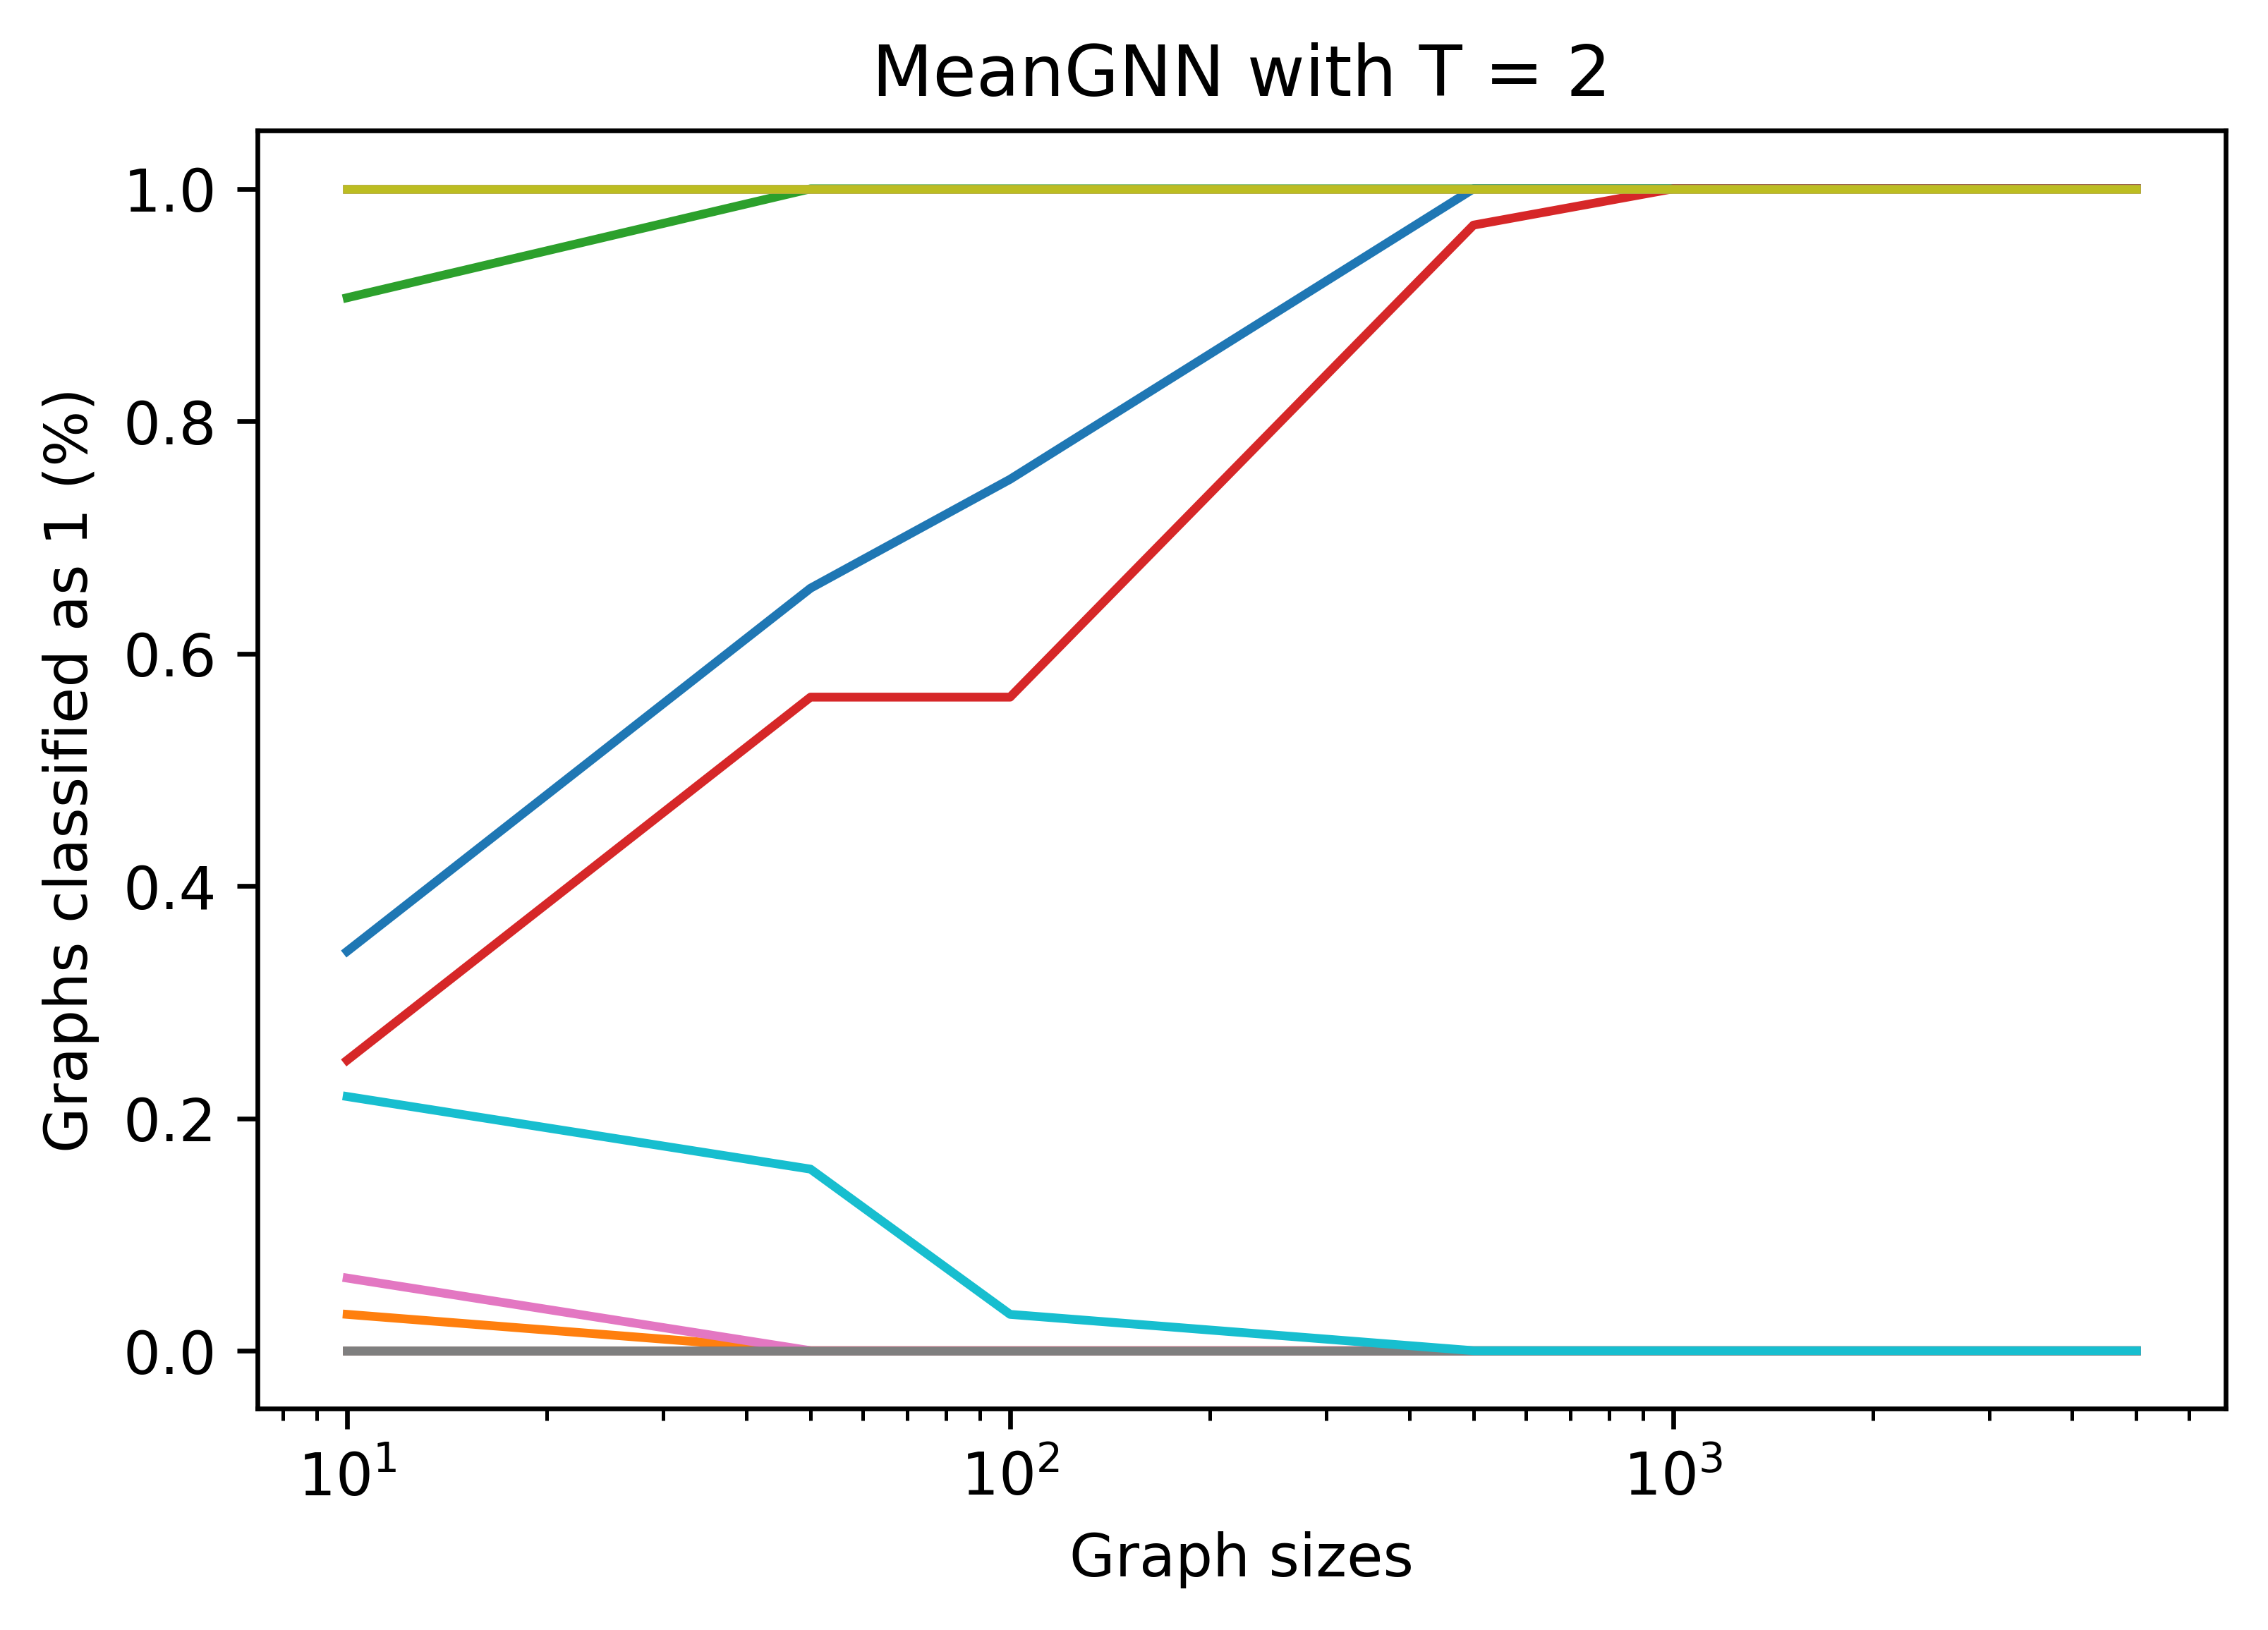

In [13]:
for y in csv_numLayer_2:
  y = [item/32 for item in y]
  plt.plot(x,y)# divide by 32

plt.xlabel('Graph sizes')
plt.ylabel('Graphs classified as 1 (%)')
plt.xscale("log")
plt.title(f'MeanGNN with T = 2')
plt.savefig('/content/drive/MyDrive/Colab Notebooks/.../GNN0-1/SelfGNN/MeanGNN with T = 2')
plt.show()

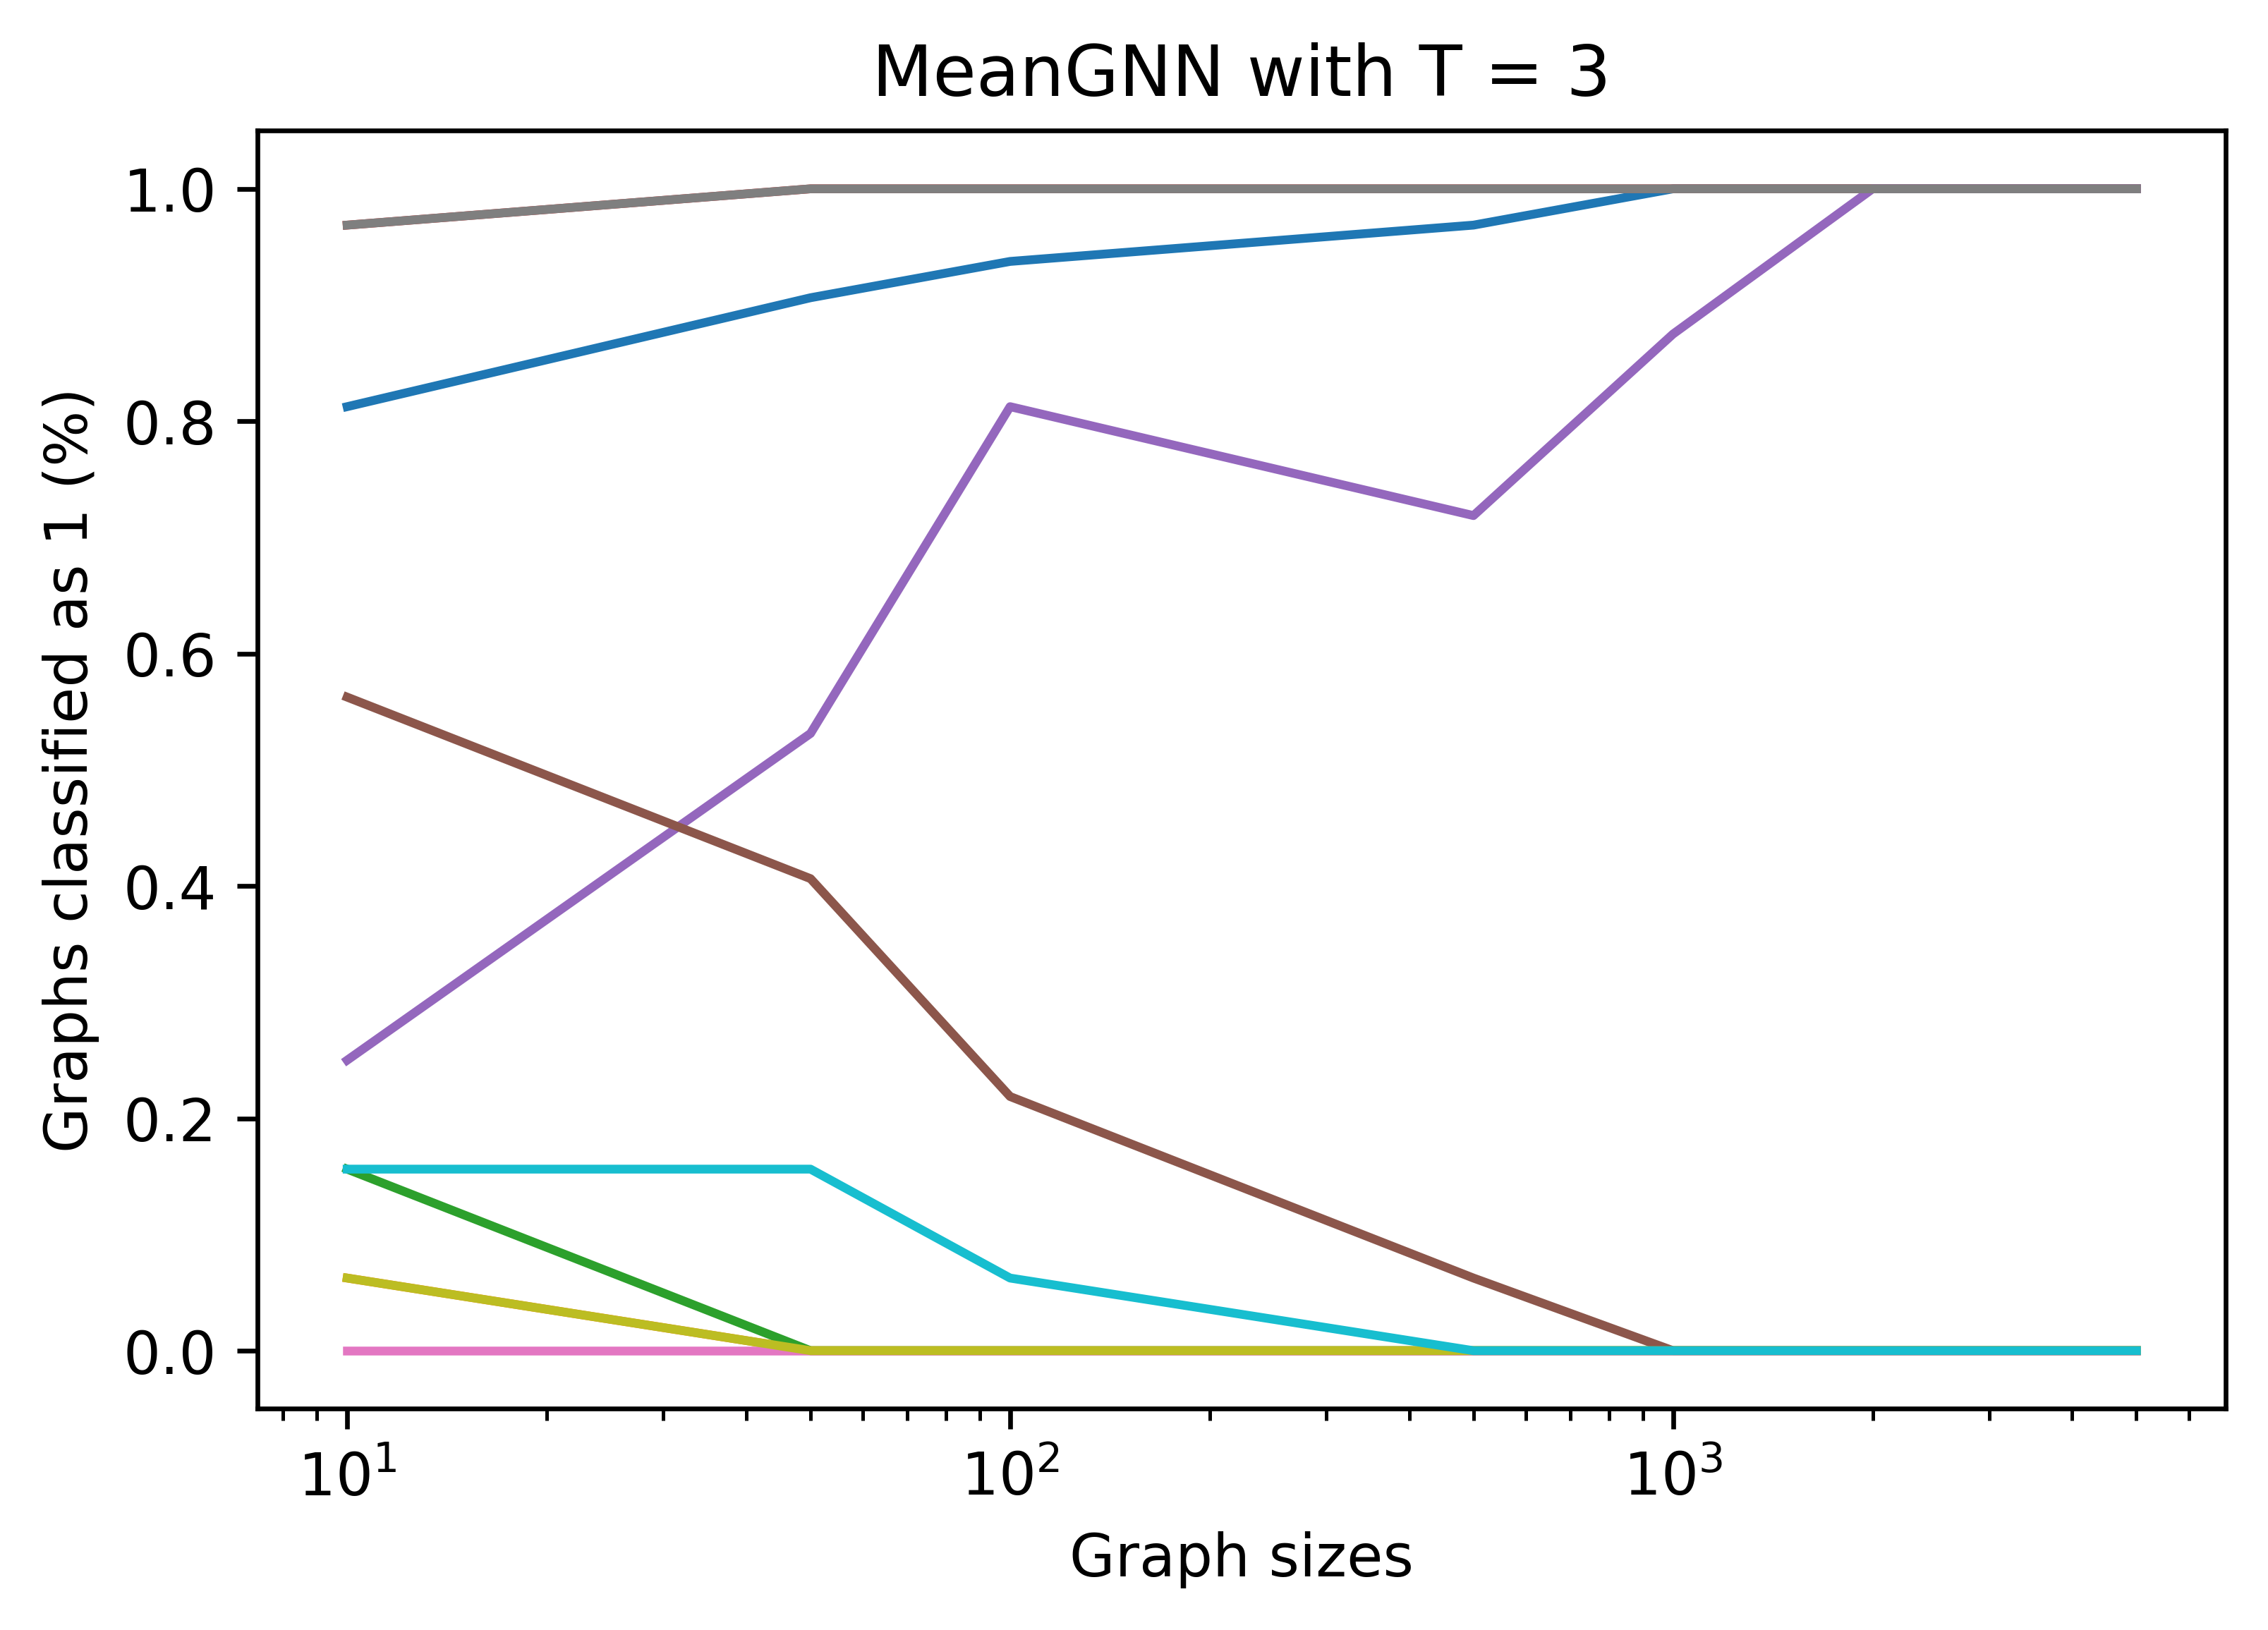

In [14]:
for y in csv_numLayer_3:
  y = [item/32 for item in y]
  plt.plot(x,y)# divide by 32

plt.xlabel('Graph sizes')
plt.ylabel('Graphs classified as 1 (%)')
plt.xscale("log")
plt.title(f'MeanGNN with T = 3')
plt.savefig('/content/drive/MyDrive/Colab Notebooks/.../GNN0-1/SelfGNN/MeanGNN with T = 3')
plt.show()

In [ ]:
import time
time.sleep(100000000)

KeyboardInterrupt: ignored